In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader
import torch

In [9]:
# Read in our data, and fill missing values
data = pd.read_csv("test_data/clean_weather.csv", index_col=0)
data = data.ffill()
# Display a sequence of temperatures
data["tmax"].head(10)
# Turn our sequence into a single row of data
data["tmax"].head(10).to_numpy()[np.newaxis,:]

from sklearn.preprocessing import StandardScaler
import math

# Define predictors and target
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train, valid, test sets
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape

import torch
# Convert scaled and split data into PyTorch tensors
train_input_tensor = torch.tensor(train_x, dtype=torch.float32)
valid_input_tensor = torch.tensor(valid_x, dtype=torch.float32)
test_input_tensor = torch.tensor(test_x, dtype=torch.float32)

train_target_tensor = torch.tensor(train_y, dtype=torch.float32)
valid_target_tensor = torch.tensor(valid_y, dtype=torch.float32)
test_target_tensor = torch.tensor(test_y, dtype=torch.float32)


# Create a TensorDataset
train_dataset = TensorDataset(train_input_tensor, train_target_tensor)
val_dataset = TensorDataset(valid_input_tensor, valid_target_tensor)
test_dataset =  TensorDataset(test_input_tensor, test_target_tensor)


# Optionally create a validation dataset using the remaining data if needed
train_input_tensor.shape, train_target_tensor.shape, valid_input_tensor.shape, valid_target_tensor.shape, test_input_tensor.shape, test_target_tensor.shape

(torch.Size([9456, 3]),
 torch.Size([9456, 1]),
 torch.Size([2026, 3]),
 torch.Size([2026, 1]),
 torch.Size([2027, 3]),
 torch.Size([2027, 1]))

In [10]:
from torch.utils.data import Dataset, DataLoader
import torch

class ReachDataset(Dataset):
    def __init__(self, features, labels, sequence_length=7):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        # Calculate number of full reaches in the dataset
        return len(self.features) // self.sequence_length

    def __getitem__(self, index):
        # Get the full reach sequence
        start = index * self.sequence_length
        end = start + self.sequence_length
        return self.features[start:end], self.labels[start:end]

# Assuming 'features' and 'labels' are your full datasets
train_dataset = ReachDataset(train_input_tensor, train_target_tensor)
valid_dataset =  ReachDataset(valid_input_tensor, valid_target_tensor)
test_dataset = ReachDataset(test_input_tensor, test_target_tensor)
# Create DataLoader
batch_size = 1  # Adjust based on your system's memory and the model's capacity
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

C:\Users\user\AppData\Local\Temp\ipykernel_16844\2284159216.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_16844\2284159216.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32)


In [11]:
import torch
import torch.nn as nn

class NeuralRNN(nn.Module):
    def __init__(self, input_size=538, hidden_size=64, num_layers=1, output_size=45, dropout=0.1):
        super(NeuralRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,dropout=dropout if num_layers > 1 else 0)

        # Define the nromal rnn layer
        #self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Define the fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, return_states=False):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        #out, _ = self.rnn(x, h0)

        
        if return_states:
            return self.fc(out), hn, cn
        else:
            return self.fc(out)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the main loop varibles
num_epochs = 5
lr = 0.0003

# Set Variables for stopping training loop early
min_val_loss = float('inf')
stop_max = 10
stop_count = 0
early_stop = True

# Set the main components of the netowrk
neural_rnn = NeuralRNN(input_size=3, hidden_size=64, num_layers=2, output_size=1, dropout=0.2).to(device)
loss_function = torch.nn.MSELoss()  # Mean Squared Error Loss, or choose another appropriate to your task
optimizer = torch.optim.Adam(neural_rnn.parameters(), lr=lr, weight_decay=0.01)  # Using Adam optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=1e-5, verbose=True)
training_outputs = []
training_targets = []
val_outputs = []
validation_targets = []

# Determine the device dynamically
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


# Run the training loop
for epoch in range(num_epochs):
    print(f'--- epoch: {epoch +1} ----')

    neural_rnn.train()
    train_loss = 0.0
    batch_counter = 0
    total_train_loss = 0
    total_samples = 0

    for inputs, targets in train_loader:
        batch_counter += 1
        optimizer.zero_grad()
        outputs = neural_rnn(inputs)
        training_outputs.append(outputs.detach().numpy())
        training_targets.append(targets.detach().numpy())

    
        loss = loss_function(outputs, targets)

        loss.backward()
        optimizer.step()
        training_target = targets

        train_loss += loss.item() * inputs.size(0)  # Multiply by batch size to undo averaging in loss calculation

        total_train_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    avg_train_loss = total_train_loss / total_samples
    print(f'Training Loss: {avg_train_loss:.4f}')

    neural_rnn.eval()
    val_loss = 0.0
    total_val_loss = 0
    total_val_samples = 0

    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output_val = neural_rnn(inputs)
        val_outputs.append(output_val.detach().numpy())
        validation_targets.append(targets.detach().numpy())

        loss = loss_function(output_val, targets)
        val_loss += loss.item() * inputs.size(0)
        val_targets = targets

        total_val_loss += loss.item() * inputs.size(0)
        total_val_samples += inputs.size(0)

    avg_val_loss = total_val_loss / total_val_samples
    print(f'Validation Loss: {avg_val_loss:.4f}')


     # Learning Rate Scheduler
    scheduler.step(avg_val_loss)

    if early_stop:
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss 
            stop_count = 0
            print(f'stop_count RESET')
        else:
            stop_count += 1
            print(f'PEPARING TO STOP IN: {stop_count-10}, min_loss_val: {min_val_loss}')

            if stop_count >= stop_max:
                break


    # print(f' Training Loss: {train_loss:.3f}, Vald Loss: {val_loss}')
    print(f'Training Prediction: {outputs[:,0].detach().numpy()}, training Target: {training_target[:,0].detach().numpy()}')
    print(f'Val Prediction: {output_val[:,1].detach().numpy()}, Val Target: {val_targets[:,1].detach().numpy()}')

Using device: cpu
--- epoch: 1 ----
Training Loss: 2423.4061
Validation Loss: 1402.0914
stop_count RESET
Training Prediction: [[23.725576]], training Target: [[59.]]
Val Prediction: [[31.025583]], Val Target: [[85.]]
--- epoch: 2 ----
Training Loss: 729.3261
Validation Loss: 422.4318
stop_count RESET
Training Prediction: [[38.591232]], training Target: [[59.]]
Val Prediction: [[48.97105]], Val Target: [[85.]]
--- epoch: 3 ----
Training Loss: 208.3821
Validation Loss: 140.6414
stop_count RESET
Training Prediction: [[47.593586]], training Target: [[59.]]
Val Prediction: [[60.18438]], Val Target: [[85.]]
--- epoch: 4 ----
Training Loss: 106.6286
Validation Loss: 98.6595
stop_count RESET
Training Prediction: [[51.17665]], training Target: [[59.]]
Val Prediction: [[64.611336]], Val Target: [[85.]]
--- epoch: 5 ----
Training Loss: 84.2255
Validation Loss: 58.4796
stop_count RESET
Training Prediction: [[54.36909]], training Target: [[59.]]
Val Prediction: [[68.65965]], Val Target: [[85.]]


In [15]:
training_outputs = np.array(training_outputs)
training_targets = np.array(training_targets)
val_outputs = np.array(val_outputs)
validation_targets = np.array(validation_targets)

print(training_outputs.shape, training_targets.shape, training_outputs[:,0,0,0].shape, training_targets[:,0,0,0].shape)
training_outputs[:,0,6,0], training_targets[:,0,0,0], 
val_outputs[:,0,6,0], validation_targets[:,0,6,0],

(6750, 1, 7, 1) (6750, 1, 7, 1) (6750,) (6750,)


(array([32.265244, 32.265244, 32.265244, ..., 68.300446, 70.7942  ,
        69.88823 ], dtype=float32),
 array([77., 62., 66., ..., 67., 77., 73.], dtype=float32))

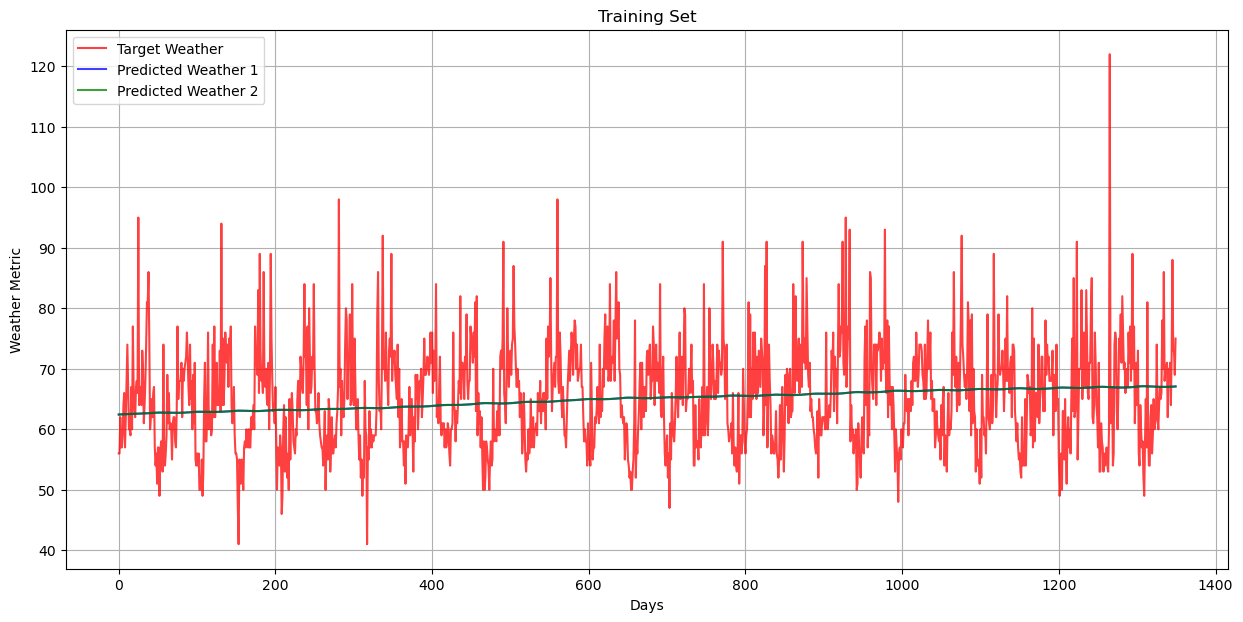

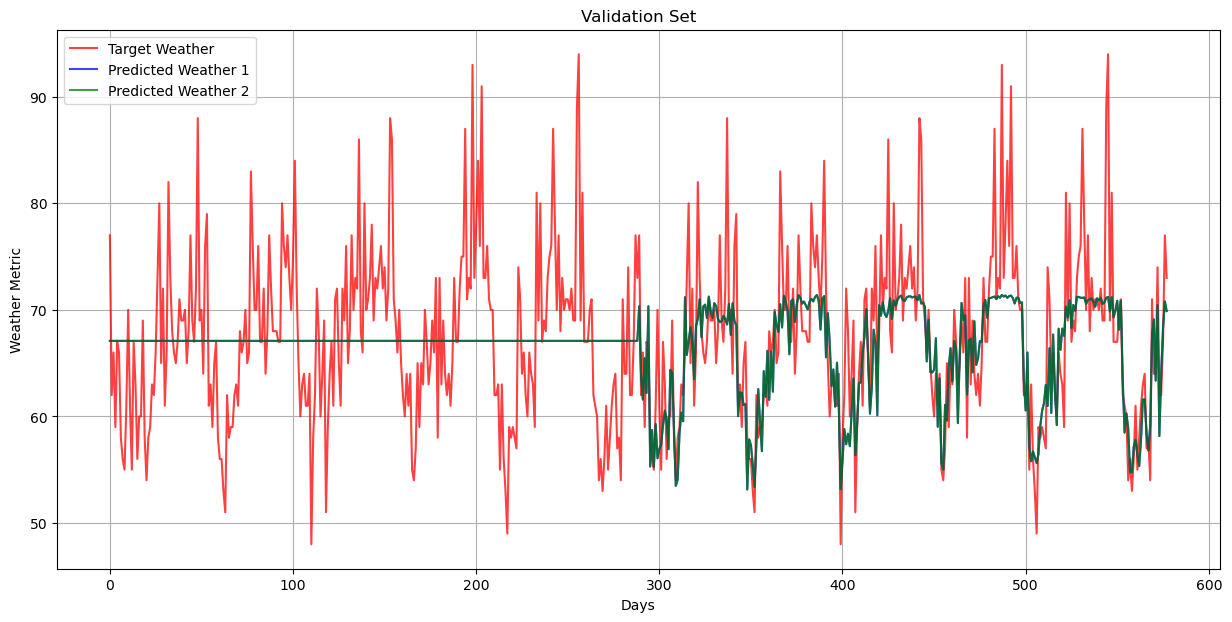

In [16]:
import matplotlib.pyplot as plt

epoch_to_eval = 3


index_start = 1350 * epoch_to_eval
index_end = (1350 * epoch_to_eval) +1350

plt.figure(figsize=(15, 7))
# plt.plot(targets, label='Actual Weather', color='blue', alpha=0.75)
plt.plot(training_targets[index_start:index_end,0,6,0], label='Target Weather', linestyle='-', color='red', alpha=0.75)

plt.plot(training_outputs[index_start:index_end,0,6,0], label='Predicted Weather 1', linestyle='-', color='blue', alpha=0.75)
plt.plot(training_outputs[index_start:index_end,0,6,0], label='Predicted Weather 2', linestyle='-', color='green', alpha=0.75)

plt.title('Training Set')
plt.xlabel('Days')
plt.ylabel('Weather Metric')
plt.legend()
plt.grid(True)
plt.show()


index_start = 289 * epoch_to_eval
index_end = (289 * epoch_to_eval) +1350


plt.figure(figsize=(15, 7))
# plt.plot(targets, label='Actual Weather', color='blue', alpha=0.75)
plt.plot(validation_targets[index_start:index_end,0,6,0], label='Target Weather', linestyle='-', color='red', alpha=0.75)

plt.plot(val_outputs[index_start:index_end,0,6,0], label='Predicted Weather 1', linestyle='-', color='blue', alpha=0.75)
plt.plot(val_outputs[index_start:index_end,0,6,0], label='Predicted Weather 2', linestyle='-', color='green', alpha=0.75)

plt.title('Validation Set')
plt.xlabel('Days')
plt.ylabel('Weather Metric')
plt.legend()
plt.grid(True)
plt.show()


## Unseen Data Test

In [17]:
class FullSequenceDataset(Dataset):
    def __init__(self, features, labels):
        # Ensure data is in the correct shape [1, seq_length, feature_size]
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(0)      # Add batch dimension

    def __len__(self):
        return 1  # We have only one batch in this dataset

    def __getitem__(self, index):
        # Return the whole sequence
        return self.features[index], self.labels[index]

test_dataset = FullSequenceDataset(test_input_tensor, test_target_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # No need to shuffle, only one batch

C:\Users\user\AppData\Local\Temp\ipykernel_16844\1254602587.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
C:\Users\user\AppData\Local\Temp\ipykernel_16844\1254602587.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(0)      # Add batch dimension


Overall Mean Squared Error Loss: 37.47676086425781
MSE for embedding 0: 37.47676086425781


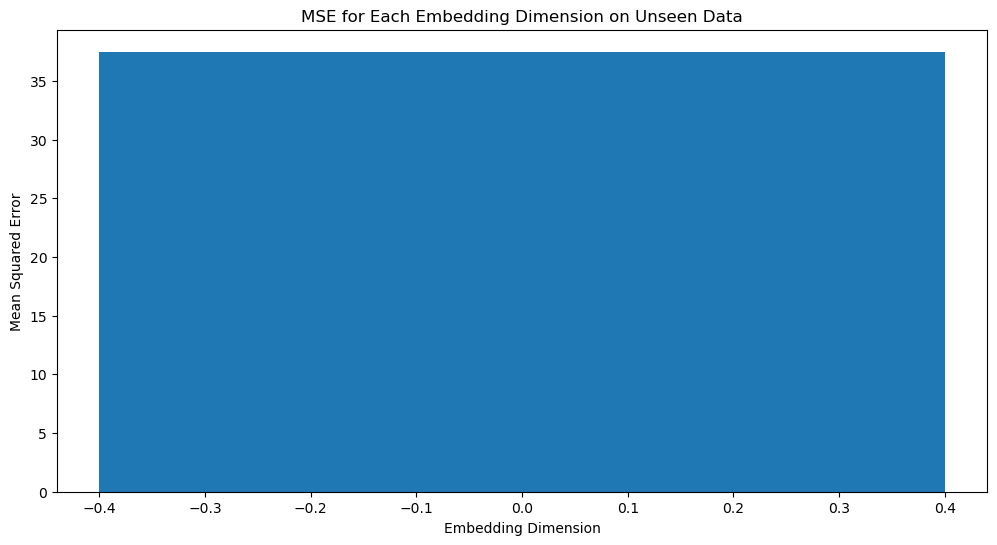

((1, 1, 2027, 1), (1, 1, 2027, 1))

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

# Assuming neural_rnn_loaded is already loaded and set to evaluation mode
neural_rnn.eval()
test_outputs = []
test_targets = []

# Directly access the full sequence since you know you have one full batch
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)

with torch.no_grad():
    outputs = neural_rnn(inputs)
    test_outputs.append(outputs.detach().numpy())
    test_targets.append(targets.detach().numpy())
    mse_loss = nn.MSELoss()
    loss = mse_loss(outputs, targets)
    print("Overall Mean Squared Error Loss:", loss.item())

# Calculate MSE for each embedding dimension
mse_per_embedding = []
for i in range(outputs.shape[2]):  # Loop across the embedding dimension
    mse = mse_loss(outputs[0, :, i], targets[0, :, i]).item()
    mse_per_embedding.append(mse)
    print(f"MSE for embedding {i}: {mse}")

# Visualize the MSE across all embeddings
plt.figure(figsize=(12, 6))
plt.bar(range(len(mse_per_embedding)), mse_per_embedding)
plt.xlabel('Embedding Dimension')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Each Embedding Dimension on Unseen Data')
plt.show()

test_outputs = np.array(test_outputs)
test_targets = np.array(test_targets)
test_outputs.shape, test_targets.shape

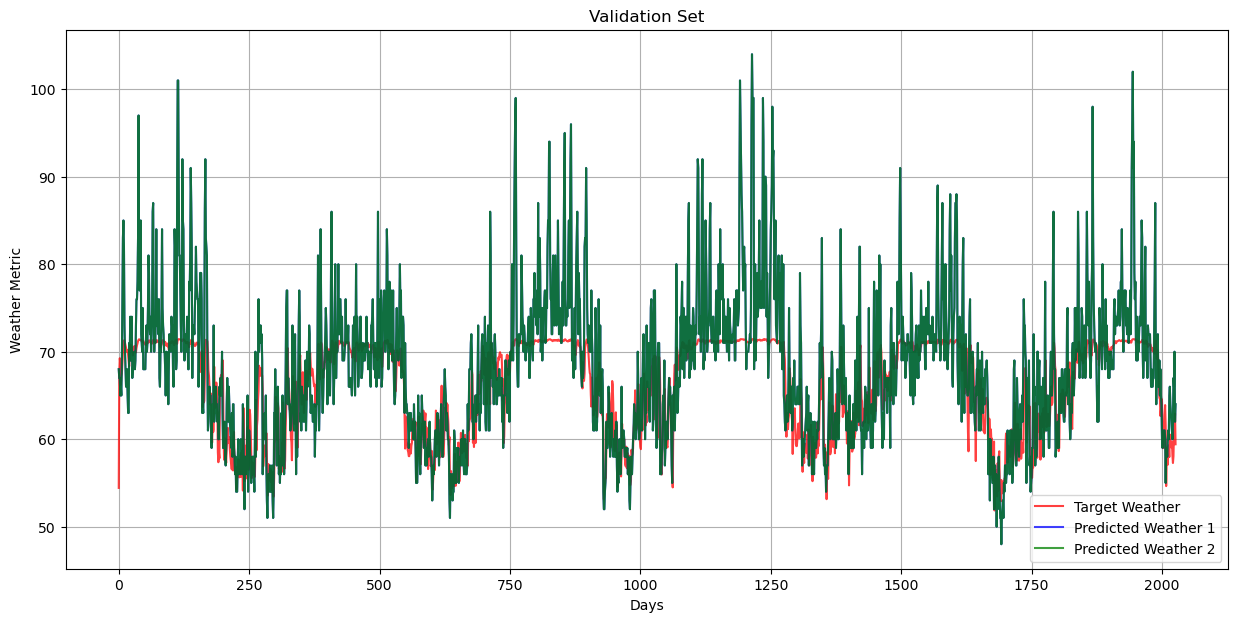

In [19]:
import matplotlib.pyplot as plt

epoch_to_eval = 1


index_start = 289 * epoch_to_eval
index_end = (289 * epoch_to_eval) +1350


plt.figure(figsize=(15, 7))
# plt.plot(targets, label='Actual Weather', color='blue', alpha=0.75)
plt.plot(test_outputs[0,0,:,0], label='Target Weather', linestyle='-', color='red', alpha=0.75)

plt.plot(test_targets[0,0,:,0], label='Predicted Weather 1', linestyle='-', color='blue', alpha=0.75)
plt.plot(test_targets[0,0,:,0], label='Predicted Weather 2', linestyle='-', color='green', alpha=0.75)

plt.title('Validation Set')
plt.xlabel('Days')
plt.ylabel('Weather Metric')
plt.legend()
plt.grid(True)
plt.show()